In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
import initial_distributions

In [2]:
def calc_psi(H_t,h,H_ref):
  """
  Calculate (initial) psi/ surface-to-reference distance.
  """
  return H_t + h - H_ref

def melt_rate(m_p, m_i, h, h_max):
    """
    Calculate total melt rate m based on albedo of melt ponds.
    :param m_p: enhancement factor due to the presence of melt ponds
    :param m_i: constant summer melt rate for unponded ice
    :param h: current pond depth
    :param h_max: global pond depth after which the ice-melting process doesn't quickens
    :return:
    """
    if h > h_max:
      return 1+ m_p/m_i
    else:
      return 1+ m_p/m_i * h/h_max

In [58]:
def melt_drain(h, delta_t, m, rho_ice, rho_water, s):
    """
    Discretisation of dhdt. Calculates next value for h.
    :param h: np.array; current height of water
    :param delta_t: time step
    :param m: melting rate
    :param rho_ice: ice density
    :param rho_water: water density
    :param s: vertical seepage rate
    :return:
    """
    return h + delta_t * (m * (rho_ice / rho_water) - s)

def heaviside(h):
    """
    Prevents the meltwater depth h from becoming negative.
    """
    return np.where(h < 0, 0, 1)

In [4]:
def gradient(x, dx, roll, axis):
    '''
    calculates the gradient between two cells

    Arguments:
        x -- 2D array
        dx -- space interval
        roll -- where to roll (-1, +1)
        axis -- along which axis to roll

    Returns:
        grad -- the gradient between two cells
    '''

    grad = (np.roll(x, roll, axis=axis) - x) /dx

    return grad

def horizontal_flow(psi, dt, dx):
    '''
    Calculates the the horizontal flow for all cells based on the ice topography psi
    Note: happens after vertical drainage

    Arguments:
        psi -- 2D array of the ice topography
        dt -- time increment
        dx -- space increment

    Returns:
        dh -- change in water height due to horizontal flow
    '''

    # define constants
    mu = 1.79e-3 # [kg/(m*s)] dynamic viscosity
    pi = 3e-9 # [m^2] horizontal permability
    rho_water = 1000 # [kg/m^3] desity
    g = 9.832 # [m/s^2] gravitational acceleration at the poles

    # calculate all constants togeter
    const = dt * dx * g * rho_water * pi / mu

    # define parameters for the neighbors
    axes = [0, 1]
    rolls = [-1, 1]

    # initialize zero array of water height change
    dh = np.zeros(psi.shape)

    # calculate the in / out flow for each neighbor and sum them up
    for ax in axes:
        for roll in rolls:

            grad = gradient(psi, dx, roll, ax)

            dh[grad >= 0] += np.roll(psi, roll, axis=ax)[grad >= 0] * const * grad[grad >= 0]
            dh[grad < 0] += psi[grad < 0] * const * grad[grad < 0]

    return dh

In [5]:
def calc_H0(psi_0,rho_ice,rho_water):
    """
    Initial ice thickness by assuming hydrostatic equilibrium.
    :param psi_0:
    :param rho_ice:
    :param rho_water:
    :return:
    """
    return psi_0/(1-(rho_ice/rho_water))

def calc_dHtdt(H,m):
  """
  Update of ice-surface height, evolution.
  :param H: Ice height
  :param m: melting rate
  """
  return heaviside(H)*-m

def next_Ht(dHtdt,delta_t,H_t):
  return dHtdt*delta_t + H_t


In [90]:
# Completly fixed constants

# Water and ice densities - fixed values
rho_water = 1000
rho_ice = 900

# Seepage rate
s = 0.8 / (3600 * 24)

pi_h = 3e-9 # horizontal permeability of sea ice
delta_x = 1

m_i = 1.2 / (3600 * 24) # cm/day; unpounded ice melt rate
m_p = 2 # cm/day; maximum melt pond enhanced melt rate

In [91]:
m = m_i # should really follow equation 4

# Size of the array
size = 125

# Timestep
delta_t = 5

psi_0 = np.random.normal(loc = 5, scale = 1, size = (size, size))
#psi_0 = heaviside(psi_0) * psi_0

#psi_0, X,Y = initial_distributions.valley_distr(size=size)
#psi_0 = heaviside(psi_0) * psi_0

In [92]:
# Initialise grid water levels - no negative values
h = np.zeros(shape = (size, size))

# Total ice thickness at initial condition
H0 = calc_H0(psi_0,rho_ice,rho_water)

# Reference point - zero
H_ref = np.zeros(h.shape)

# Set the initial conditions
Ht = psi_0 # initially no water, so psi = Ht assuming H_ref = 0
psi= psi_0
H = H0

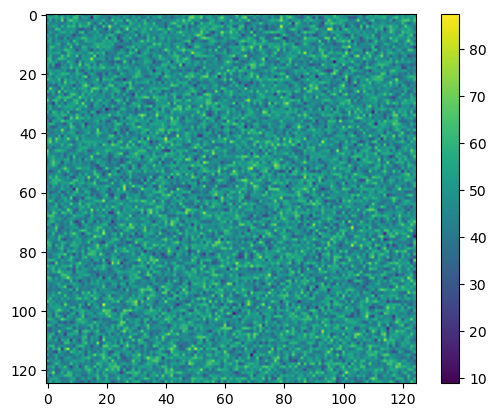

In [97]:
Hs = []
for _ in range(10000):

    h = heaviside(h) * melt_drain(h, delta_t, m, rho_ice, rho_water, s)
    H = heaviside(H) * (H - delta_t * m)
    Ht = heaviside(H) * ((-H-h) / (rho_ice / rho_water -1))
    psi = heaviside(psi) * calc_psi(Ht, h, H_ref)
    # dh = horizontal_flow(psi, delta_t, delta_x)
    # h[h>0] = h[h>0] + dh[h>0]
    # psi = calc_psi(Ht, h, H_ref)




    # # dhdt = calc_dhdt(h, rho_water,rho_ice,s,pi_h, psi, m, delta_x)
    # # cur_h = next_h(dhdt,delta_t,h)
    # Ht = next_Ht(calc_dHtdt(H,m),delta_t,Ht)
    # # h = cur_h
    # H = H + calc_dHtdt(H,m)*delta_t
    # # psi = calc_psi(Ht, h, H_ref) # psi for the next step
    # print(np.mean(calc_dHtdt(H,m)))
    # Hs.append(np.mean(H))


plt.imshow(H)
plt.colorbar()

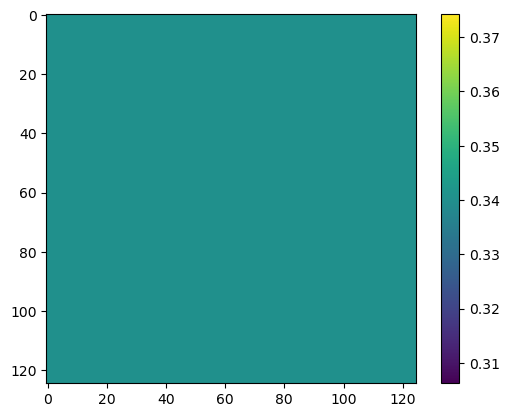

In [98]:
plt.imshow(h)
plt.colorbar()

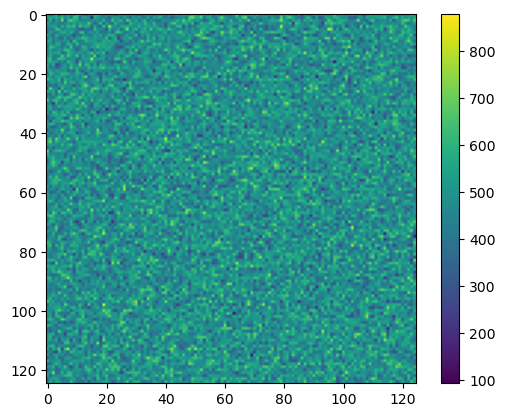

In [100]:
plt.imshow(psi)
plt.colorbar()